Введите размер поля n:  20
Введите вероятность появления дерева ε (0-1):  0.1
Введите вероятность удара молнии θ (0-1):  0.01


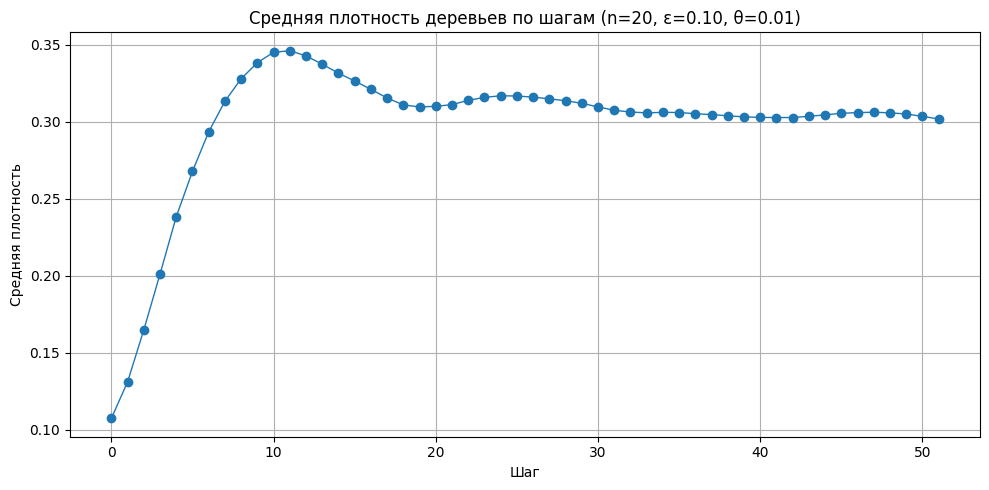

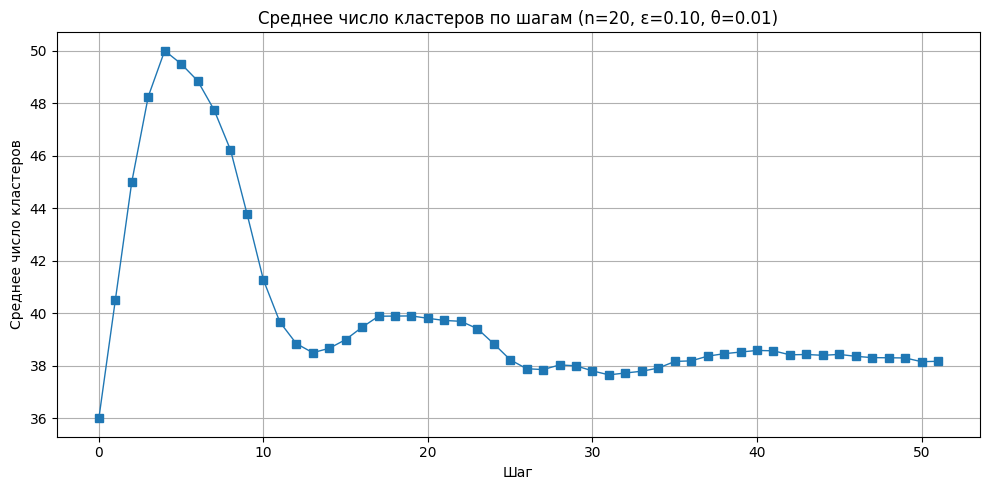

In [2]:
import numpy as np
import pygame
import random
import time
import matplotlib.pyplot as plt
from multiprocessing import Process

# Размеры клетки и дополнительная высота для вывода текста (расширено для нескольких строк)
CELL_SIZE = 50
TEXT_AREA_HEIGHT = 150  # увеличенная высота для вывода статистики

# Инициализация pygame
pygame.init()

# Загрузка изображений
TREE_IMAGE = pygame.image.load('tree.png')  # Замените на путь к вашему изображению дерева
FIRE_IMAGE = pygame.image.load('fire.png')  # Замените на путь к вашему изображению огня

# Масштабируем изображения до нужного размера
TREE_IMAGE = pygame.transform.scale(TREE_IMAGE, (CELL_SIZE, CELL_SIZE))
FIRE_IMAGE = pygame.transform.scale(FIRE_IMAGE, (CELL_SIZE, CELL_SIZE))

# Цвет для пустых клеток
EMPTY_COLOR = (255, 255, 255)

# Функция для инициализации поля
def create_forest(n):
    return np.full((n, n), None)

# Функция для расчёта текущей плотности деревьев
def density_trees(forest):
    n = forest.shape[0]
    total_cells = n * n
    tree_count = sum(1 for i in range(n) for j in range(n) if forest[i, j] == 'Tree')
    return tree_count / total_cells

# Функция для получения соседей клетки (четырёх смежных)
def get_neighbors(i, j, n):
    neighbors = []
    if i > 0:         neighbors.append((i - 1, j))
    if i < n - 1:     neighbors.append((i + 1, j))
    if j > 0:         neighbors.append((i, j - 1))
    if j < n - 1:     neighbors.append((i, j + 1))
    return neighbors

# Функция для подсчёта числа кластеров деревьев
def cluster_count(forest):
    n = forest.shape[0]
    visited = np.full((n, n), False)
    clusters = 0
    def dfs(i, j):
        stack = [(i, j)]
        while stack:
            ci, cj = stack.pop()
            if visited[ci, cj]: continue
            visited[ci, cj] = True
            for ni, nj in get_neighbors(ci, cj, n):
                if not visited[ni, nj] and forest[ni, nj] == 'Tree': stack.append((ni, nj))
    for i in range(n):
        for j in range(n):
            if forest[i, j] == 'Tree' and not visited[i, j]:
                clusters += 1
                dfs(i, j)
    return clusters

# Функция для обновления состояния клеток. Возвращает текущую плотность.
def update_forest(forest, epsilon, theta):
    n = forest.shape[0]
    fire_spread, to_burn = [], []
    for i in range(n):
        for j in range(n):
            if forest[i, j] is None and random.random() < epsilon: forest[i, j] = 'Tree'
    for i in range(n):
        for j in range(n):
            if forest[i, j] == 'Fire':
                for ni, nj in get_neighbors(i, j, n):
                    if forest[ni, nj] == 'Tree': fire_spread.append((ni, nj))
                to_burn.append((i, j))
    for ni, nj in fire_spread:
        if forest[ni, nj] == 'Tree': forest[ni, nj] = 'Fire'
    for i, j in to_burn:
        forest[i, j] = None
    for i in range(n):
        for j in range(n):
            if forest[i, j] == 'Tree' and random.random() < theta: forest[i, j] = 'Fire'
    return density_trees(forest)

# Функция для рисования поля
def draw_forest(screen, forest, n):
    for i in range(n):
        for j in range(n):
            if forest[i, j] == 'Tree': screen.blit(TREE_IMAGE, (j * CELL_SIZE, i * CELL_SIZE))
            elif forest[i, j] == 'Fire': screen.blit(FIRE_IMAGE, (j * CELL_SIZE, i * CELL_SIZE))
    pygame.draw.line(screen, (0, 0, 0), (0, n * CELL_SIZE), (n * CELL_SIZE, n * CELL_SIZE), 2)

# Основная функция симуляции
def main():
    # Параметры симуляции
    n = int(input("Введите размер поля n: "))
    epsilon = float(input("Введите вероятность появления дерева ε (0-1): "))
    theta = float(input("Введите вероятность удара молнии θ (0-1): "))
    # Настройка окна
    width, height = n * CELL_SIZE, n * CELL_SIZE + TEXT_AREA_HEIGHT
    screen = pygame.display.set_mode((width, height))
    pygame.display.set_caption("Модель лесных пожаров")
    font = pygame.font.SysFont("arial", 24)
    forest = create_forest(n)
    stats_steps = 300
    density_history, clusters_history = [], []
    total_d = total_c = 0

    clock = pygame.time.Clock()
    step = 0
    while step < stats_steps:
        d = update_forest(forest, epsilon, theta)
        c = cluster_count(forest)
        step += 1
        total_d += d
        total_c += c
        density_history.append(total_d/step)
        clusters_history.append(total_c/step)

        screen.fill(EMPTY_COLOR)
        draw_forest(screen, forest, n)
        stats = [f"Шаг {step}/{stats_steps}  Текущая плотность деревьев:  {d:.2f}",
               f"Средняя плотность деревьев:  {total_d/step:.2f}",
               f"Текущее количество кластеров:  {c}",
               f"Среднее количество кластеров:  {total_c/step:.2f}"
        ]
        for idx, line in enumerate(stats):
            screen.blit(font.render(line, True, (0,0,0)),
                        (10, n*CELL_SIZE + 10 + idx*30))
        pygame.display.flip()
        for ev in pygame.event.get():
            if ev.type == pygame.QUIT:
                step = stats_steps
                break
        time.sleep(0.05)
        clock.tick(10)
    pygame.quit()
    return density_history, clusters_history, n, epsilon, theta

if __name__ == "__main__":
    density_history, clusters_history, n, epsilon, theta = main()
    # График средней плотности
    plt.figure(figsize=(10, 5))
    plt.plot(density_history, marker='o', linewidth=1)
    plt.title(f"Средняя плотность деревьев по шагам (n={n}, ε={epsilon:.2f}, θ={theta:.2f})")
    plt.xlabel('Шаг')
    plt.ylabel('Средняя плотность')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # График среднего числа кластеров
    plt.figure(figsize=(10, 5))
    plt.plot(clusters_history, marker='s', linewidth=1)
    plt.title(f"Среднее число кластеров по шагам (n={n}, ε={epsilon:.2f}, θ={theta:.2f})")
    plt.xlabel('Шаг')
    plt.ylabel('Среднее число кластеров')
    plt.grid(True)
    plt.tight_layout()
    plt.show()